In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.signal as signal
import scipy
import pandas as pd

from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from astropy.stats import gaussian_sigma_to_fwhm,gaussian_fwhm_to_sigma

import datetime
import pickle
import importlib
import json
import time
import glob

import warnings
warnings.filterwarnings("ignore")
import do_wavelet
# import the module to reimport the module
import importlib
# from interpolate_to_uniform_grid import interpolate_to_uniform_grid
import interpolate_to_uniform_grid

with open('data/selected_band.pkl','rb') as f:
    selected_band = pickle.load(f)
selected_band=selected_band[selected_band['Identified']==True]
selected_band = selected_band[selected_band['Channel']=='MEGS-A']
selected_band

wavelength_full = np.load('data/wavelength_full.npz')['wavelength_full']

# reorganzie the data

In [2]:
index=3
with open('./data/daily_df/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        daily_df=pickle.load(file)

In [3]:
columns=['median_of_mean', 'median_of_stddev', 'median_of_amplitude',
       'stddev_of_mean', 'stddev_of_stddev', 'stddev_of_amplitude',
       'median_of_doppler']

In [4]:
daily_df

,median_of_mean,median_of_stddev,median_of_amplitude,stddev_of_mean,stddev_of_stddev,stddev_of_amplitude,available_data,median_of_doppler
time,,,,,,,,
2010-04-30,15.429073,0.051824,0.000024,0.001480,0.002064,7.793197e-07,8570,-23834.703654
2010-05-01,15.429334,0.052110,0.000024,0.001508,0.002085,8.125716e-07,8579,-18771.040360
2010-05-02,15.429227,0.052250,0.000025,0.001470,0.002079,9.502054e-07,8578,-20840.551765
2010-05-03,15.428582,0.052596,0.000025,0.001581,0.002170,8.594878e-07,8639,-33371.485653
2010-05-04,15.427740,0.053171,0.000025,0.001935,0.002863,1.063874e-06,8577,-49733.628429
...,...,...,...,...,...,...,...,...
2014-05-21,15.427677,0.045880,0.000048,0.000970,0.001308,1.279573e-06,8581,-50965.623593
2014-05-22,15.427797,0.045664,0.000048,0.000947,0.001233,1.174633e-06,8582,-48637.441525
2014-05-23,15.427794,0.045812,0.000047,0.000946,0.001232,1.250052e-06,8582,-48687.114918


In [5]:
selected_band.loc[index]

Line Name                                               Fe XXIII 154
Wavelength Range                                      [15.35, 15.53]
Identified                                                      True
Temperature                                                     7.15
Accurate Wavelength                                          154.303
Initial Guess                                 [4e-05, 15.42, 0.0424]
Wavelength Index       [618, 619, 620, 621, 622, 623, 624, 625, 626]
Channel                                                       MEGS-A
Name: 3, dtype: object

In [6]:
selected_band

,Line Name,Wavelength Range,Identified,Temperature,Accurate Wavelength,Initial Guess,Wavelength Index,Channel
0,Ni XI 148,"[14.75, 14.93]",True,6.20,148.377,"[0.00011, 14.84, 0.0424]","[588, 589, 590, 591, 592, 593, 594, 595, 596]",MEGS-A
1,O VI 150,"[14.93, 15.09]",True,5.50,150.089,"[4.4e-05, 15.01, 0.0424]","[597, 598, 599, 600, 601, 602, 603, 604]",MEGS-A
2,Ni XII 152,"[15.13, 15.35]",True,6.30,152.151,"[6.5e-05, 15.22, 0.0424]","[607, 608, 609, 610, 611, 612, 613, 614, 615, ...",MEGS-A
3,Fe XXIII 154,"[15.35, 15.53]",True,7.15,154.303,"[4e-05, 15.42, 0.0424]","[618, 619, 620, 621, 622, 623, 624, 625, 626]",MEGS-A
4,Fe IX 171,"[17, 17.21]",True,6.20,171.073,"[0.0006, 17.11, 0.0424]","[700, 701, 702, 703, 704, 705, 706, 707, 708, ...",MEGS-A
5,Fe IX 174,"[17.37, 17.59]",True,6.05,174.531,"[0.00069, 17.45, 0.0424]","[719, 720, 721, 722, 723, 724, 725, 726, 727, ...",MEGS-A
6,Fe X 177,"[17.63, 17.83]",True,6.05,177.240,"[0.00045, 17.72, 0.0424]","[732, 733, 734, 735, 736, 737, 738, 739, 740, ...",MEGS-A
7,Fe XI 180,"[17.95, 18.15]",True,6.15,180.401,"[0.0006, 18.05, 0.0424]","[748, 749, 750, 751, 752, 753, 754, 755, 756, ...",MEGS-A
8,Fe XI 182,"[18.15, 18.31]",True,6.15,182.167,"[0.00013, 18.22, 0.0424]","[758, 759, 760, 761, 762, 763, 764, 765]",MEGS-A
9,Fe X 185,"[18.35, 18.59]",True,6.05,184.537,"[0.0002, 18.45, 0.0424]","[768, 769, 770, 771, 772, 773, 774, 775, 776, ...",MEGS-A


In [7]:
wavelength_list=[]
temperature_list=[]
median_of_amplitude_list=[]
median_of_mean_list=[]
median_of_stddev_list=[]
stddev_of_amplitude_list=[]
stddev_of_mean_list=[]
stddev_of_stddev_list=[]

#loop over the file of each spectrum
for index in selected_band.index:
    wavelength=selected_band.loc[index]['Accurate Wavelength']
    temperature=selected_band.loc[index]['Temperature']

    # load the daily_df
    with open('./data/daily_df/daily_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        daily_df=pickle.load(file)
    
    median_of_amplitude=daily_df['median_of_amplitude'].values
    median_of_mean=daily_df['median_of_mean'].values # do not use np.vstack, 
    median_of_stddev=daily_df['median_of_stddev'].values
    stddev_of_amplitude=daily_df['stddev_of_amplitude'].values
    stddev_of_mean=daily_df['stddev_of_mean'].values
    stddev_of_stddev=daily_df['stddev_of_stddev'].values

    wavelength_list.append(wavelength)
    temperature_list.append(temperature)
    median_of_amplitude_list.append(median_of_amplitude)
    median_of_mean_list.append(median_of_mean)
    median_of_stddev_list.append(median_of_stddev)
    stddev_of_amplitude_list.append(stddev_of_amplitude)
    stddev_of_mean_list.append(stddev_of_mean)
    stddev_of_stddev_list.append(stddev_of_stddev)

date_list=daily_df.index
    

df=pd.DataFrame({'Accurate Wavelength':wavelength_list,
                    'Temperature':temperature_list,
                    'median_of_amplitude':median_of_amplitude_list,
                    'median_of_mean':median_of_mean_list,
                    'median_of_stddev':median_of_stddev_list,
                    'stddev_of_amplitude':stddev_of_amplitude_list,
                    'stddev_of_mean':stddev_of_mean_list,
                    'stddev_of_stddev':stddev_of_stddev_list})

# save the df and date_list
with open('data/daily_reorganized/daily_reorganized.pkl','wb') as file:
    pickle.dump(df,file)
    pickle.dump(date_list,file)

In [17]:
with open ('data/daily_reorganized/daily_reorganized.pkl', 'rb') as file:
    df=pickle.load(file)
    date_list=pickle.load(file)

# Plot

## interplote issue

In [2]:
with open ('data/daily_reorganized/daily_reorganized.pkl', 'rb') as file:
    df=pickle.load(file)
    date_list=pickle.load(file)

In [6]:
df.head()

,Accurate Wavelength,Temperature,median_of_amplitude,median_of_mean,median_of_stddev,stddev_of_amplitude,stddev_of_mean,stddev_of_stddev
0,148.377,6.20,"[9.235386513047728e-05, 9.184627861863145e-05,...","[14.843828313970889, 14.843908889291669, 14.84...","[0.03480645843921967, 0.03502454458961865, 0.0...","[1.478074035294303e-06, 1.5937474201142842e-06...","[0.0004899972212168447, 0.0005108259053247209,...","[0.0004078912736480709, 0.0004124449925509439,..."
1,150.089,5.50,"[3.562827498153191e-05, 3.59443986353062e-05, ...","[15.015846758526715, 15.015788047364527, 15.01...","[0.04273331707788898, 0.04283564241132388, 0.0...","[9.974960725584185e-07, 1.1421043613212962e-06...","[0.0010780289572547433, 0.000993045328938674, ...","[0.0011332620621315624, 0.001062285260197288, ..."
2,152.151,6.30,"[4.177264449536093e-05, 4.170728382108122e-05,...","[15.222579660191744, 15.222771497149802, 15.22...","[0.04963146143954718, 0.05005205859672242, 0.0...","[1.0689598088477338e-06, 1.0619353380638212e-0...","[0.0013983561684433208, 0.0009852699797575516,...","[0.001482433172221537, 0.0012965253217288185, ..."
3,154.303,7.15,"[2.4474322879537715e-05, 2.4494514225623494e-0...","[15.429073229219176, 15.429333855668022, 15.42...","[0.05182410890598135, 0.05211005084382409, 0.0...","[7.793197491002778e-07, 8.125716147689223e-07,...","[0.001480449157721307, 0.0015075352017464231, ...","[0.0020643526863483126, 0.00208521658999969, 0..."
4,171.073,6.20,"[0.0006733172250257813, 0.0006829490751589835,...","[17.109492595724575, 17.109552576804614, 17.10...","[0.03310848578901575, 0.03321008723592947, 0.0...","[9.724296607346886e-06, 8.20161148724891e-06, ...","[0.0003042517446814926, 0.0003302327512586855,...","[0.00023801122412461592, 0.0002163563408591401..."


### test 

In [17]:
importlib.reload(interpolate_to_uniform_grid)

<module 'interpolate_to_uniform_grid' from 'd:\\py_repo\\EVE-spectrum-correction\\Period_EVE_v1\\interpolate_to_uniform_grid.py'>

intput shape:x: (10,) y: (13,) z: (10, 13)
output shape:xi: (13, 30) yi: (13, 30) zi: (13, 30)


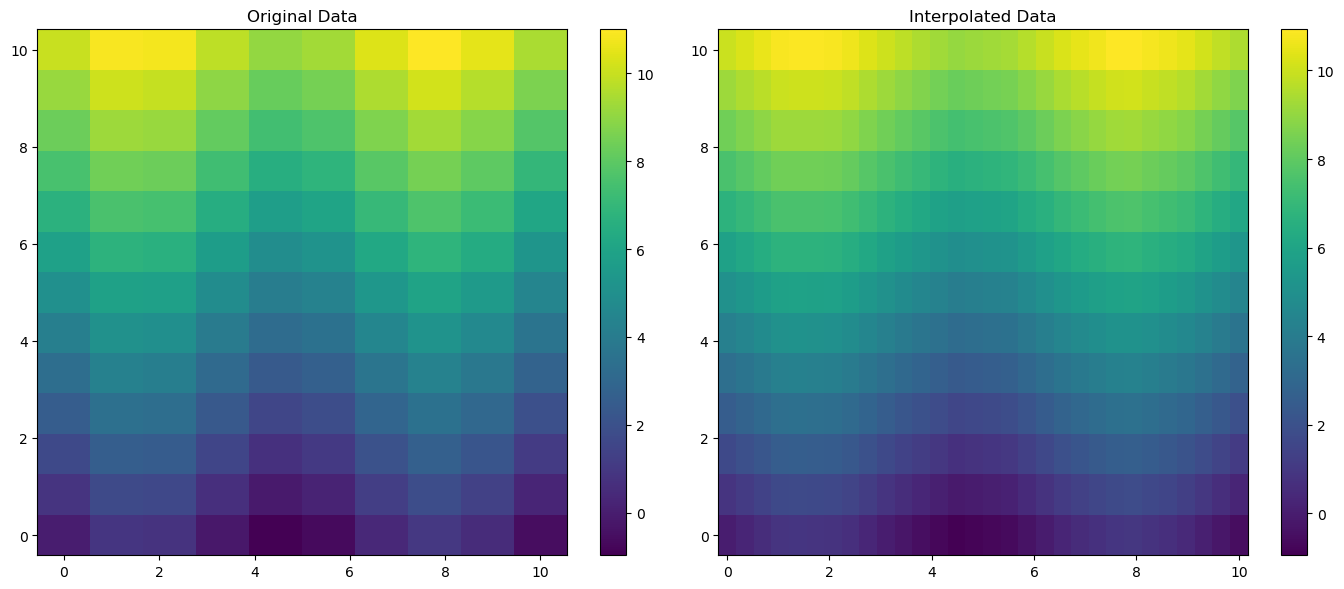

In [4]:
# Original non-uniform grid data
x = np.linspace(0, 10, 10)
y = np.linspace(0, 10, 13)
X, Y = np.meshgrid(x, y,indexing='ij')
Z = np.sin(X) +Y

# Apply the interpolation function with increased resolution
xi, yi, zi = interpolate_to_uniform_grid.interpolate_to_uniform_grid(x=x, y=y, z=Z, scale_factor_x=3, scale_factor_y=1, method='linear')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original data
cax_orig = axes[0].pcolormesh(X, Y, Z, shading='auto')
fig.colorbar(cax_orig, ax=axes[0])
axes[0].set_title('Original Data')

# Interpolated data
cax_interp = axes[1].pcolormesh(xi, yi, zi, shading='auto')
fig.colorbar(cax_interp, ax=axes[1])
axes[1].set_title('Interpolated Data')

plt.tight_layout()
plt.show()


In [4]:
x=date_list
y=df['Accurate Wavelength'].values

# y=np.array([])
z=np.vstack(df['median_of_amplitude'].values)

X, Y = np.meshgrid(x, y,indexing='xy')

print(x.shape)
print(y.shape)
print(z.shape)

xi, yi, zi =interpolate_to_uniform_grid(x=np.array([]),y=y,z=np.log10(z),scale_factor_x=1,scale_factor_y=10,
                                                                    method='linear')

(1487,)
(24,)
(24, 1487)
input shape:x shape:(1487,), y shape:(24,), z shape:(24, 1487)
output shape: xi shape:(240, 1487), yi shape:(240, 1487), zi shape:(240, 1487)


## plot doppler result

In [8]:
with open ('data/wavelet_df/wavelet_result.pkl','rb') as f:
    df = pickle.load(f)
df.head()

,Line Name,Wavelength Range,Identified,Temperature,Accurate Wavelength,Initial Guess,Wavelength Index,Channel,amplitude periods,mean periods,stddev periods,doppler period,doppler global_ws
0,Ni XI 148,"[14.75, 14.93]",True,6.20,148.377,"[0.00011, 14.84, 0.0424]","[588, 589, 590, 591, 592, 593, 594, 595, 596]",MEGS-A,"[nan, 239.23269615331523, 834.9916623932752]","[14.11642653698231, 27.616775785822178, 51.370...","[13.026210611381849, 28.5429121955423, 53.1942...","[2.0660872954985074, 2.2660872954985076, 2.466...","[1944557.8565380678, 2908381.3057330726, 38450..."
1,O VI 150,"[14.93, 15.09]",True,5.50,150.089,"[4.4e-05, 15.01, 0.0424]","[597, 598, 599, 600, 601, 602, 603, 604]",MEGS-A,"[26.701602015238816, 259.2727393339304, 853.33...","[13.481030488216206, 30.499353485649124, 53.08...","[26.806840490411698, 134.2682339833241, 249.25...","[2.0660872954985074, 2.2660872954985076, 2.466...","[1192975.5412373617, 1663035.5009875353, 21173..."
2,Ni XII 152,"[15.13, 15.35]",True,6.30,152.151,"[6.5e-05, 15.22, 0.0424]","[607, 608, 609, 610, 611, 612, 613, 614, 615, ...",MEGS-A,"[27.117571524498473, 255.21324632341287, 841.8...","[13.942558059668865, 27.37371178753602, 225.83...","[nan, 231.9194905042568]","[2.0660872954985074, 2.2660872954985076, 2.466...","[2239690.551712684, 3451485.887674397, 4640289..."
3,Fe XXIII 154,"[15.35, 15.53]",True,7.15,154.303,"[4e-05, 15.42, 0.0424]","[618, 619, 620, 621, 622, 623, 624, 625, 626]",MEGS-A,"[27.110493792061085, 255.86209714354735, 840.5...","[13.964131113675196, 27.74466947337789, 405.26...",[238.73143424250176],"[2.0660872954985074, 2.2660872954985076, 2.466...","[2305089.093644407, 3449054.0017540213, 456876..."
4,Fe IX 171,"[17, 17.21]",True,6.20,171.073,"[0.0006, 17.11, 0.0424]","[700, 701, 702, 703, 704, 705, 706, 707, 708, ...",MEGS-A,"[26.70760787502137, 73.73206066062396, 236.822...","[13.532917814204527, 29.054406650080086, 51.68...","[2.0660872954985074, 26.431649936195047, 390.3...","[2.0660872954985074, 2.2660872954985076, 2.466...","[2605630.5494091106, 3709261.8275745297, 47986..."


In [17]:
doppler_period=df.loc[0,'doppler period']

x=df['Temperature'].values
y=doppler_period
z=np.log10(np.vstack(df['doppler global_ws'].values))

In [18]:
X,Y=np.meshgrid(x,y,indexing='ij')

In [19]:
print(X.shape,Y.shape,z.shape)

(24, 7470) (24, 7470) (24, 7470)


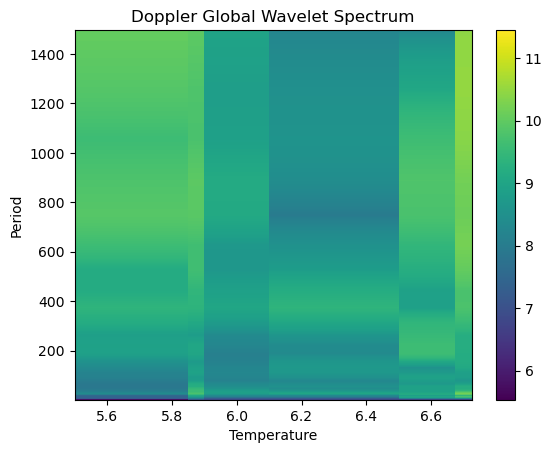

In [23]:
fig,ax=plt.subplots()
cax=ax.pcolormesh(X,Y,z)
ax.set_xlabel('Temperature')
ax.set_ylabel('Period')
ax.set_title('Doppler Global Wavelet Spectrum')
fig.colorbar(cax)



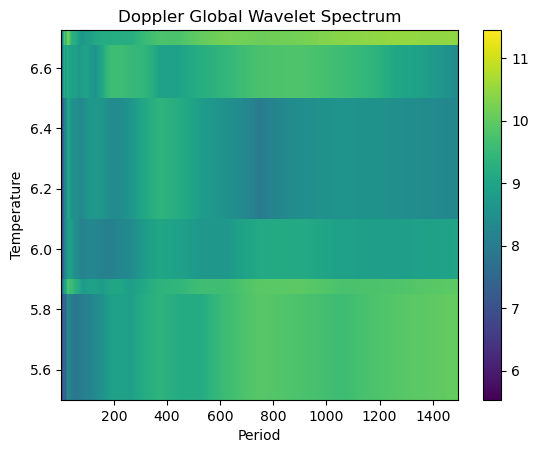

In [25]:
fig,ax=plt.subplots()
cax=ax.pcolormesh(Y.T,X.T,z.T)
ax.set_xlabel('Period')
ax.set_ylabel('Temperature')
ax.set_title('Doppler Global Wavelet Spectrum')
fig.colorbar(cax)

In [26]:
xi, yi, zi =interpolate_to_uniform_grid.interpolate_to_uniform_grid(x=x, y=y, z=z, scale_factor_x=1, scale_factor_y=10, method='linear')

intput shape:x: (24,) y: (7470,) z: (24, 7470)
output shape:xi: (74700, 24) yi: (74700, 24) zi: (74700, 24)


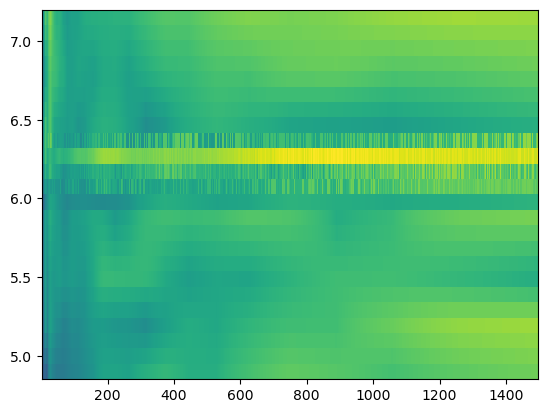

In [27]:
plt.pcolormesh(yi.T,xi.T,zi.T)

In [5]:
def combined_2d_plot(xi,yi,zi):
    

    fig,ax=plt.subplots()
    cax=ax.pcolormesh(xi,yi,zi,shading='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_xlabel('Periods (d)')
    ax.set_ylabel('Wavelength (Angstrom)')
    ax.set_title('log(Wavelet Power)')


    fig = go.Figure(data=[go.Surface(
    z=zi, 
    x=xi, 
    y=yi,
    colorscale='thermal',
    hovertemplate=
    'Periods (d): %{x}<br>' +
    'Temperature: %{y}<br>' +
    'Log10(Global WS): %{z}<br>' +
    '<extra></extra>'  # Hide the secondary box
    )])

    # Update plot layout
    fig.update_layout(title='3D Surface Plot', 
                    scene=dict(
                        xaxis=dict(title='Periods (d)'#, range=[20, 38]
                                   ),
                        yaxis=dict(title='Temperature'),
                        zaxis=dict(title='log10(Global WS)'),
                        xaxis_title='Periods (d)',  # X-axis label
                        yaxis_title='Temperature',  # Y-axis label
                        zaxis_title='Log10(Global WS)'  # Z-axis label
                    ))


    # Showing the plot
    fig.show()

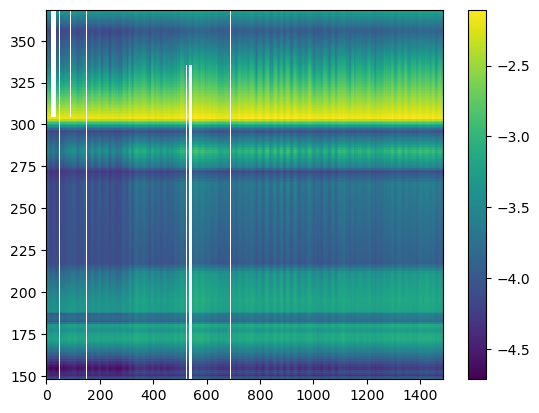

In [34]:
fig,ax=plt.subplots()
cax=ax.pcolormesh(xi,yi,zi,shading='auto')
# add a colorbar
fig.colorbar(cax)
# Reverse the y-axis
# ax.invert_yaxis()

In [17]:
selected_band

,Line Name,Wavelength Range,Identified,Temperature,Accurate Wavelength,Initial Guess,Wavelength Index,Channel
0,Ni XI 148,"[14.75, 14.93]",True,6.20,148.377,"[0.00011, 14.84, 0.0424]","[588, 589, 590, 591, 592, 593, 594, 595, 596]",MEGS-A
1,O VI 150,"[14.93, 15.09]",True,5.50,150.089,"[4.4e-05, 15.01, 0.0424]","[597, 598, 599, 600, 601, 602, 603, 604]",MEGS-A
2,Ni XII 152,"[15.13, 15.35]",True,6.30,152.151,"[6.5e-05, 15.22, 0.0424]","[607, 608, 609, 610, 611, 612, 613, 614, 615, ...",MEGS-A
3,Fe XXIII 154,"[15.35, 15.53]",True,7.15,154.303,"[4e-05, 15.42, 0.0424]","[618, 619, 620, 621, 622, 623, 624, 625, 626]",MEGS-A
4,Fe IX 171,"[17, 17.21]",True,6.20,171.073,"[0.0006, 17.11, 0.0424]","[700, 701, 702, 703, 704, 705, 706, 707, 708, ...",MEGS-A
5,Fe IX 174,"[17.37, 17.59]",True,6.05,174.531,"[0.00069, 17.45, 0.0424]","[719, 720, 721, 722, 723, 724, 725, 726, 727, ...",MEGS-A
6,Fe X 177,"[17.63, 17.83]",True,6.05,177.240,"[0.00045, 17.72, 0.0424]","[732, 733, 734, 735, 736, 737, 738, 739, 740, ...",MEGS-A
7,Fe XI 180,"[17.95, 18.15]",True,6.15,180.401,"[0.0006, 18.05, 0.0424]","[748, 749, 750, 751, 752, 753, 754, 755, 756, ...",MEGS-A
8,Fe XI 182,"[18.15, 18.31]",True,6.15,182.167,"[0.00013, 18.22, 0.0424]","[758, 759, 760, 761, 762, 763, 764, 765]",MEGS-A
9,Fe X 185,"[18.35, 18.59]",True,6.05,184.537,"[0.0002, 18.45, 0.0424]","[768, 769, 770, 771, 772, 773, 774, 775, 776, ...",MEGS-A
